In [1]:
import torch
# import requests

# ! wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
# ! unzip -d weights -j weights.zip
from models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

# load model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64, complex_trans_conv=True)
model.eval()

# non-strict, because we only stored decoder weights (not CLIP weights)
model.load_state_dict(torch.load('/home/t-qimhuang/weights/clipseg/rd64-uni-refined.pth'), strict=False)

_IncompatibleKeys(missing_keys=['clip_model.positional_embedding', 'clip_model.text_projection', 'clip_model.logit_scale', 'clip_model.visual.class_embedding', 'clip_model.visual.positional_embedding', 'clip_model.visual.proj', 'clip_model.visual.conv1.weight', 'clip_model.visual.ln_pre.weight', 'clip_model.visual.ln_pre.bias', 'clip_model.visual.transformer.resblocks.0.attn.in_proj_weight', 'clip_model.visual.transformer.resblocks.0.attn.in_proj_bias', 'clip_model.visual.transformer.resblocks.0.attn.out_proj.weight', 'clip_model.visual.transformer.resblocks.0.attn.out_proj.bias', 'clip_model.visual.transformer.resblocks.0.ln_1.weight', 'clip_model.visual.transformer.resblocks.0.ln_1.bias', 'clip_model.visual.transformer.resblocks.0.mlp.c_fc.weight', 'clip_model.visual.transformer.resblocks.0.mlp.c_fc.bias', 'clip_model.visual.transformer.resblocks.0.mlp.c_proj.weight', 'clip_model.visual.transformer.resblocks.0.mlp.c_proj.bias', 'clip_model.visual.transformer.resblocks.0.ln_2.weight',

Load and normalize `example_image.jpg`. You can also load through an URL.

In [21]:
# load and normalize image
input_image = Image.open('example_image.jpg')
# input_image = Image.open('/home/t-qimhuang/disk/robot_dataset/final_test_set/run5_test105/image/video_0022___01_franka___01184_2023-08-12_0030_right/00011.jpg')
H, W = input_image.size[1], input_image.size[0]

# or load from URL...
# image_url = 'https://farm5.staticflickr.com/4141/4856248695_03475782dc_z.jpg'
# input_image = Image.open(requests.get(image_url, stream=True).raw)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((352, 352)),
])
img = transform(input_image).unsqueeze(0)

Predict and visualize (this might take a few seconds if running without GPU support)

[Text(0, -15, 'a glass'),
 Text(0, -15, 'something to fill'),
 Text(0, -15, 'wood')]

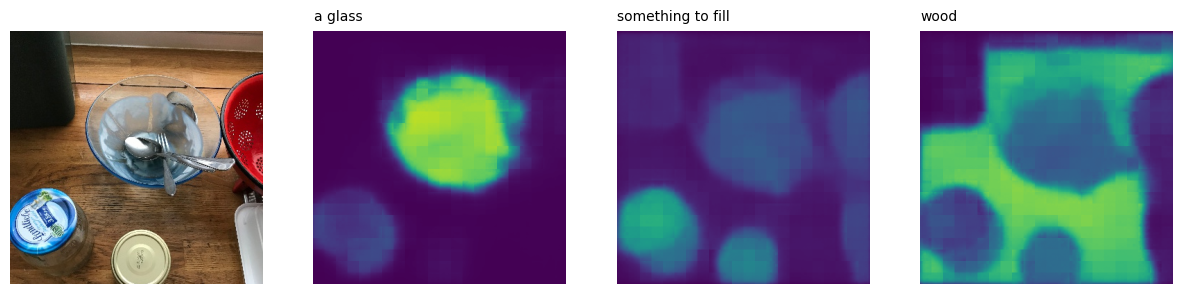

In [22]:
# prompts = ['robot arm', 'gripper', 'robot']
prompts = ['a glass', 'something to fill', 'wood']

# predict
with torch.no_grad():
    preds = model(img.repeat(3,1,1,1), prompts)[0]

# visualize prediction
_, ax = plt.subplots(1, 4, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0]), vmin=0, vmax=1) for i in range(3)]
[ax[i+1].text(0, -15, prompts[i]) for i in range(3)]

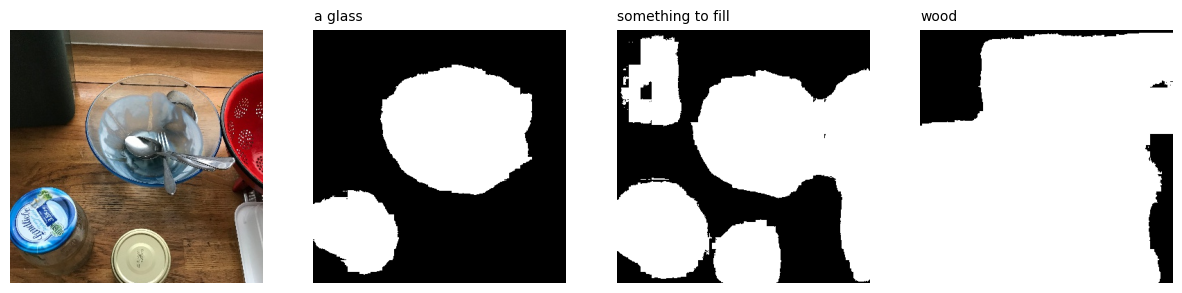

In [23]:
## show the binary mask of each prompt
_, ax = plt.subplots(1, 4, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]

images = torch.sigmoid(preds)

import cv2

ax[0].imshow(input_image)
for i in range(3):
    mask = (images[i][0] > 0.1).cpu().numpy().astype('uint8') * 255
    ## resize mask to original image size
    mask = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST)
    ax[i+1].imshow(mask, cmap='gray')
    ax[i+1].text(0, -15, prompts[i])
plt.show()


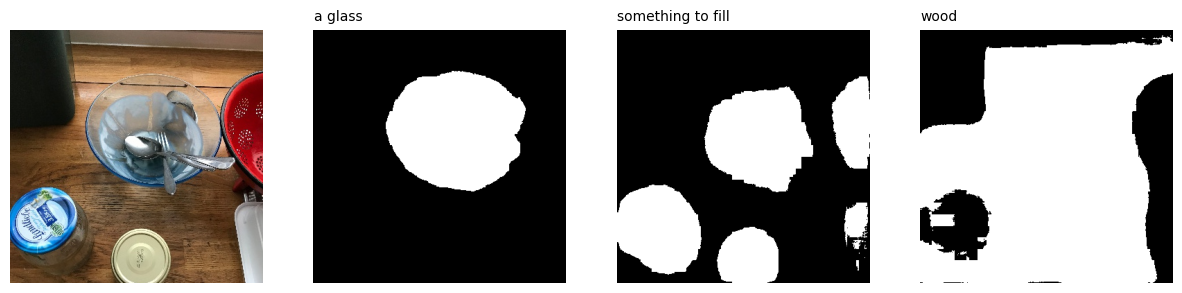

In [29]:
# save the binary masks but after sigmoid, normalise again 
_, ax = plt.subplots(1, 4, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]

images = torch.sigmoid(preds)
ax[0].imshow(input_image)

import cv2 

for i in range(3):
    normalised = (images[i] - images[i].min()) / (images[i].max() - images[i].min())

    mask = (normalised[0] > 0.3).cpu().numpy().astype('uint8') * 255
    ## resize mask to original image size
    mask = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(f'mask_{prompts[i].replace(" ", "_")}.png', mask)
    ax[i+1].imshow(mask, cmap='gray')
    ax[i+1].text(0, -15, prompts[i])
plt.show()  